In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TUXML_CSV_FILENAME="./config_bdd.csv"

# sanity check CSV
with open(TUXML_CSV_FILENAME, "r") as file:
    k = file.readline()
    t = k.split(",")
    s = set(t)
    assert(len(t) == len(s)) # unique number of options/features/column names

# parsing for real with pandas 
rawtuxdata = pd.read_csv(open(TUXML_CSV_FILENAME, "r"))

basic_head = ["cid", "time", "date"] # "compile"
size_methods = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]


### basic stats about options and remove of unique values 
## could be improved 

tri_state_values = ['y', 'n', 'm']

ftuniques = []
freq_ymn_features = []
non_tristate_options = []

for col in rawtuxdata:
    ft = rawtuxdata[col]    
    # eg always "y"
    if len(ft.unique()) == 1:
        ftuniques.append(col)
    # only tri-state values (y, n, m) (possible TODO: handle numerical/string options)    
    elif all(x in tri_state_values for x in ft.unique()):     #len(ft.unique()) == 3: 
        freq = ft.value_counts(normalize=True)
        freqy = 0
        freqn = 0
        freqm = 0
        if ('y' in freq.index):
            freqy = freq['y']
        if ('n' in freq.index):
            freqn = freq['n']
        if ('m' in freq.index):
            freqm = freq['m']
        freq_ymn_features.append((col, freqy, freqm, freqn))
    else:
        if not (col in size_methods): 
            non_tristate_options.append(col)
        

### TODO: we want to keep all quantitative values!
# non_tristate_options.remove('LZO') # ('vmlinux')

# we want to keep measurements (that are not tristate ;)) 
# non_tristate_options = list(set(non_tristate_options) - set(size_methods))

#### print options with unique values
# options with only one value eg always "y"
#i = 0
#for ft in ftuniques:
#    print(ft + " (" + str(i) + ")")
#    i = i + 1

print("Original size (#configs/#options) of the dataset " + str(rawtuxdata.shape))
print ("Number of options with only one value (eg always y): " + str(pd.DataFrame(ftuniques).shape))

# maybe we can drop options with only one unique value (no interest for machine learning)
# TODO: maybe we can rely on more traditional feature reduction techniques
# TODO: need to think about *when* to apply the removal 
rawtuxdata.drop(columns=ftuniques,inplace=True) 
## non_tristate_options include basic stuff like date, time, cid but also string/numerical options
print ("Non tri-state value options (eg string or integer or hybrid values): " 
       + str(pd.DataFrame(non_tristate_options).shape) + " ") 
#      + str(pd.DataFrame(non_tristate_options)))


print ("Predictor variables: " + str(rawtuxdata.drop(columns=non_tristate_options).columns.size))
# frequency of y, m, and n values 
#plt.figure()
#pd.DataFrame(freq_ymn_features, columns=["feature", "freqy", "freqm", "freqn"]).plot(kind='hist', alpha=0.8) #plot()
#plt.show()


    



/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1150,6015,6026,7726) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Original size (#configs/#options) of the dataset (800, 12798)
Number of options with only one value (eg always y): (3443, 1)
Non tri-state value options (eg string or integer or hybrid values): (143, 1) 
Predictor variables: 9212


In [2]:
'X86_64' in ftuniques, 'DEBUG_INFO' in ftuniques, 'GCOV_PROFILE_ALL' in ftuniques, 'KASAN' in ftuniques, 'UBSAN_SANITIZE_ALL' in ftuniques, 'RELOCATABLE' in ftuniques, 'XFS_DEBUG' in ftuniques, 'AIC7XXX_BUILD_FIRMWARE' in ftuniques, 'AIC79XX_BUILD_FIRMWARE' in ftuniques, 'WANXL_BUILD_FIRMWARE' in ftuniques

(True, True, True, True, True, False, True, True, True, True)

In [3]:
if 'RELOCATABLE' in rawtuxdata.columns:
    print(rawtuxdata.query("RELOCATABLE == 'y'")[['cid', 'RELOCATABLE']])

       cid RELOCATABLE
13   92013           y
51   92051           y
56   92056           y
58   92058           y
66   92066           y
67   92067           y
68   92068           y
69   92069           y
94   92094           y
98   92098           y
99   92099           y
116  92116           y
123  92123           y
150  92150           y
162  92162           y
176  92176           y
188  92188           y
190  92190           y
195  92195           y
203  92203           y
208  92208           y
219  92219           y
228  92228           y
229  92229           y
237  92237           y
241  92241           y
251  92251           y
253  92253           y
255  92255           y
276  92276           y
..     ...         ...
518  92518           y
529  92529           y
534  92534           y
545  92545           y
563  92563           y
565  92565           y
581  92581           y
586  92586           y
611  92611           y
613  92613           y
614  92614           y
622  92622 

In [4]:
print("Data exploration")

Data exploration


In [5]:
# BUGS EXPLORATION
def bug_exploration():
    rawtuxdata.query("AIC7XXX_BUILD_FIRMWARE == 'y'")[['cid', 'vmlinux']]
    rawtuxdata.query("AIC79XX_BUILD_FIRMWARE == 'y'")[['cid', 'vmlinux']]
    rawtuxdata.query("WANXL_BUILD_FIRMWARE == 'y'")[['cid', 'vmlinux']]
    rawtuxdata.query("GENERIC_ALLOCATOR == 'n' & DRM_VBOXVIDEO == 'y'")[['cid', 'vmlinux']]
    rawtuxdata.query("GENERIC_ALLOCATOR == 'y' & DRM_VBOXVIDEO == 'y'")[['cid', 'vmlinux']]
    rawtuxdata.query("GENERIC_ALLOCATOR == 'n' & DRM_VBOXVIDEO == 'm'")[['cid', 'vmlinux']]
    return rawtuxdata.query("DRM_VBOXVIDEO == 'y'")[['cid', 'vmlinux']]

# bug_exploration()





In [6]:
#rawtuxdata[rawtuxdata['X86_64'] == 'n']
#rawtuxdata.query("X86_64 == 'n'")

In [7]:
#rawtuxdata[(rawtuxdata['DEBUG_INFO'] == 'n') & (rawtuxdata['GCOV_PROFILE_ALL'] == 'n') & (rawtuxdata['KASAN'] == 'n') & (rawtuxdata['MODULES'] == 'y')]
# rawtuxdata.query("(DEBUG_INFO == 'n') & (GCOV_PROFILE_ALL == 'n') & (KASAN == 'n') & (MODULES == 'y')")
#rawtuxdata.query("(DEBUG_INFO == 'n') & (GCOV_PROFILE_ALL == 'n') & (KASAN == 'n')").shape, rawtuxdata.shape


In [8]:
#rawtuxdata[rawtuxdata['vmlinux'] == 1168072][['cid', 'CC_OPTIMIZE_FOR_SIZE', 'DEBUG_INFO_DWARF4', 'KASAN', 'UBSAN_ALIGNMENT', 'X86_NEED_RELOCS', 'RANDOMIZE_BASE', 'GCOV_PROFILE_ALL', 'UBSAN_SANITIZE_ALL', 'DEBUG_INFO', 'MODULES', 'DEBUG_INFO_REDUCED', 'DEBUG_INFO_SPLIT']]
tiny_data = rawtuxdata.query("vmlinux == 1168072") #tiny config for X86_32
#if (len(tiny_data) > 0):
#    print(tiny_data[['cid', 'CC_OPTIMIZE_FOR_SIZE', 'DEBUG_INFO_DWARF4', 'KASAN', 'UBSAN_ALIGNMENT', 'X86_NEED_RELOCS', 'RANDOMIZE_BASE', 'GCOV_PROFILE_ALL', 'UBSAN_SANITIZE_ALL', 'DEBUG_INFO', 'MODULES', 'DEBUG_INFO_REDUCED', 'DEBUG_INFO_SPLIT']])

In [9]:
#rawtuxdata[rawtuxdata['vmlinux'] == -1]
rawtuxdata.query("vmlinux == -1")

,cid,date,time,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,...,VIDEO_S3C_CAMIF,SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH,APDS9960,SLABINFO,MICROCODE_AMD,ISDN_DRV_HISAX,CHARGER_BQ24190,SND_SOC_NAU8825,BH1750,NETWORK_FILESYSTEMS
72,92072,2018-07-31 21:22:43,673.648,-1,-1,-1,-1,-1,-1,-1,...,n,n,n,y,n,n,n,n,n,n
120,92120,2018-07-31 21:37:08,701.833,-1,-1,-1,-1,-1,-1,-1,...,n,n,n,y,n,n,y,n,n,n


In [10]:
#rawtuxdata[rawtuxdata['vmlinux'] == 1168072]['MODULES']
rawtuxdata.query("vmlinux == 1168072")['MODULES'] #tiny config for X86_32

Series([], Name: MODULES, dtype: object)

In [11]:
# playing a bit with the data 
rawtuxdata.dtypes
# 'DEBUG_INFOO' in list(pd.DataFrame(non_tristate_options)[0]) # 
# tuxdata['DEBUG_INFO'].unique()
#tuxdata['OUTPUT_FORMAT'].dtypes
#tuxdata['DEFAULT_HOSTNAME'].unique()

#rawtuxdata[:5]
rawtuxdata[:20]['vmlinux']
#tuxdata[:5]['CONFIG_DEBUG_INFO']
#tuxdata['ARCH_HAS_SG_CHAIN'].unique()
#tuxdata['ARCH_HAS_SG_CHAIN'].astype('category')

0     18958784
1     14020304
2     18864856
3     36473592
4     41781760
5     27830312
6     25922512
7     54560488
8     41066208
9     29413160
10    56241632
11    23782696
12    18674696
13    36511960
14    12373376
15    21035336
16    42141216
17    22889760
18    24473760
19    19251632
Name: vmlinux, dtype: int64

In [12]:
rawtuxdata.shape, rawtuxdata.query("vmlinux != -1").shape

((800, 9355), (798, 9355))

In [13]:
print("some configurations may have X86_32 (coz we have tested/tried some options and there are in the database)")
# we only keep X86_64 configurations
#rawtuxdata = rawtuxdata[rawtuxdata['X86_64'] == 'y'] ### TODO: I've impression it's not the most effective way (wrt memory) to filter 
if 'X86_64' in rawtuxdata.columns:
    print(rawtuxdata['X86_64'].describe())
    rawtuxdata.query("X86_64 == 'y'", inplace=True)
rawtuxdata.info(memory_usage='deep')

some configurations may have X86_32 (coz we have tested/tried some options and there are in the database)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Columns: 9355 entries, cid to NETWORK_FILESYSTEMS
dtypes: float64(1), int64(133), object(9221)
memory usage: 464.7 MB


In [14]:
from sklearn.preprocessing import *
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn import tree
import graphviz 


LEARN_COMPILATION_SUCCESS = False # costly in time and space 
compilation_status_column_name = 'compile_success'

def encode_data_compilation(rawtuxdata):
    lae = LabelEncoder()
    # we save quantitative values we want (here vmlinux, TODO: generalize)
    # the key idea is that the labelling encoder should not be applied to this kind of values (only to predictor variables!)
    # vml = rawtuxdata['LZO'] # rawtuxdata['vmlinux'] 
    o_sizes = rawtuxdata[size_methods]

    # we remove non tri state options, but TODO there are perhaps some interesting options (numerical or string) here
    #tuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=['vmlinux']).apply(le.fit_transform)
    tuxdata_for_compilation = rawtuxdata.drop(columns=non_tristate_options).drop(columns=size_methods).apply(lae.fit_transform)

    #tuxdata['vmlinux'] = vml 
    tuxdata_for_compilation[size_methods] = o_sizes
    # we can ue vmlinux since it has been restored thanks to previous line
    tuxdata_for_compilation[compilation_status_column_name] = tuxdata_for_compilation['vmlinux'] != -1
    return tuxdata_for_compilation

def learn_compilation_success(tuxdata_for_compilation):
    TESTING_SIZE=0.3 
    X_train, X_test, y_train, y_test = train_test_split(tuxdata_for_compilation.drop(columns=size_methods).drop(columns=compilation_status_column_name), tuxdata_for_compilation[compilation_status_column_name], test_size=TESTING_SIZE, random_state=0)  
    clf = tree.DecisionTreeClassifier() #GradientBoostingClassifier(n_estimators=100) #RandomForestRegressor(n_estimators=100) #   #GradientBoostingRegressor(n_estimators=100)  
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]    

    TOP_FT_IMPORTANCE=20
    print("Feature ranking: " + "top (" + str(TOP_FT_IMPORTANCE) + ")")
    for f in range(TOP_FT_IMPORTANCE): # len(indices)
        print("%d. feature %s %d (%f)" % (f + 1, tuxdata_for_compilation.columns[indices[f]], indices[f], importances[indices[f]]))
   
    
    dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=tuxdata_for_compilation.drop(columns=size_methods).drop(columns=compilation_status_column_name).columns,  
                         filled=True, rounded=True,
                         special_characters=True)  
    graph = graphviz.Source(dot_data)  
    graph.render("TUXML compilation sucess")
    
    acc = accuracy_score (y_test, y_pred)
    prec = precision_score (y_test, y_pred)
    reca = recall_score (y_test, y_pred)
    f1 = f1_score (y_test, y_pred)
    print("Accuracy score: %.2f" % (acc))
    print("Precision score: %.2f" % (prec))
    print("Recall score: %.2f" % (reca))
    print("F1 score: %.2f" % (f1))

if (LEARN_COMPILATION_SUCCESS):
    tuxdata_for_compilation = encode_data_compilation(rawtuxdata)
    tuxdata_for_compilation [compilation_status_column_name].describe()
    learn_compilation_success(tuxdata_for_compilation)

In [15]:
#rawtuxdata.query("vmlinux == -1")[['cid', 'AIC7XXX_BUILD_FIRMWARE', 'AIC79XX_BUILD_FIRMWARE', 'IPVTAP', 'WANXL_BUILD_FIRMWARE', 'TCIC']]

In [16]:
# aka MAPE
def mean_relative_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [17]:
# remove entries with same configurations
print(str(len(rawtuxdata)) + " before the removal of some entries (those with same configurations)")
# tuxdata.drop_duplicates(subset=tuxdata.columns.difference(['vmlinux']), inplace=True)
rawtuxdata.drop_duplicates(subset=rawtuxdata.columns.difference(size_methods).difference(basic_head), inplace=True)
print(str(len(rawtuxdata)) + " after the removal of some entries (those with same configurations)")

#n_failures = len(tuxdata[~np.isnan(tuxdata['vmlinux'])])
#n_failures = len(rawtuxdata.query("vmlinux != -1")) #len(tuxdata[np.isnan(tuxdata['vmlinux'])])
#print(str(n_failures) + " non-failures out of " + str(len(rawtuxdata)))

#tuxdata = tuxdata[~np.isnan(tuxdata['vmlinux'])]
#rawtuxdata = rawtuxdata[rawtuxdata['vmlinux'] != -1] #tuxdata[~np.isnan(tuxdata['vmlinux'])]
rawtuxdata.query("(vmlinux != -1) & (vmlinux != 0)", inplace=True)
print(str(len(rawtuxdata)) + " after the removal of configurations that do NOT compile")


800 before the removal of some entries (those with same configurations)
800 after the removal of some entries (those with same configurations)
798 after the removal of configurations that do NOT compile


In [18]:
rawtuxdata.query("vmlinux == 1168072") # tinyconfig with X86_32

,cid,date,time,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,...,VIDEO_S3C_CAMIF,SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH,APDS9960,SLABINFO,MICROCODE_AMD,ISDN_DRV_HISAX,CHARGER_BQ24190,SND_SOC_NAU8825,BH1750,NETWORK_FILESYSTEMS


In [19]:
rawtuxdata.query("vmlinux == 7317008") # tiny config for X86_64

,cid,date,time,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,...,VIDEO_S3C_CAMIF,SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH,APDS9960,SLABINFO,MICROCODE_AMD,ISDN_DRV_HISAX,CHARGER_BQ24190,SND_SOC_NAU8825,BH1750,NETWORK_FILESYSTEMS


<Figure size 432x288 with 0 Axes>

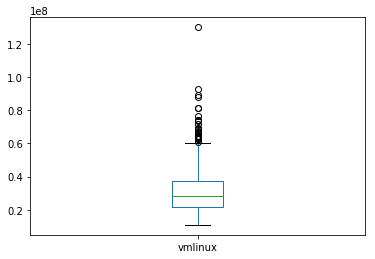

<Figure size 432x288 with 0 Axes>

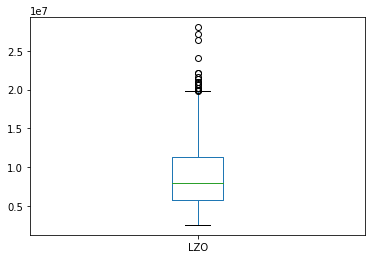

<Figure size 432x288 with 0 Axes>

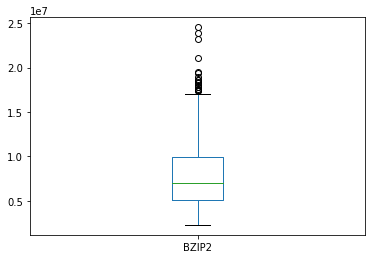

count    7.980000e+02
mean     3.127635e+07
std      1.319053e+07
min      1.089261e+07
25%      2.194921e+07
50%      2.832439e+07
75%      3.728345e+07
max      1.298963e+08
Name: vmlinux, dtype: float64

In [20]:
plt.figure()
pd.DataFrame(rawtuxdata['vmlinux']).plot.box()
plt.show(block=False)

plt.figure()
pd.DataFrame(rawtuxdata['LZO']).plot.box()
plt.show(block=False)

plt.figure()
pd.DataFrame(rawtuxdata['BZIP2']).plot.box()
plt.show(block=False)


rawtuxdata['vmlinux'].describe()


In [21]:
rawtuxdata.query("vmlinux == 1168072") # tiny config for X86_32

,cid,date,time,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,...,VIDEO_S3C_CAMIF,SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH,APDS9960,SLABINFO,MICROCODE_AMD,ISDN_DRV_HISAX,CHARGER_BQ24190,SND_SOC_NAU8825,BH1750,NETWORK_FILESYSTEMS


In [22]:
import scipy.stats
import seaborn as sns



def color_negative_positive(val, pcolor="green", ncolor="red"):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = pcolor if val > 0 else ncolor 
    if val == 0:
        color = 'black' 
    return 'color: %s' % color

compress_methods = ["GZIP", "BZIP2", "LZMA", "XZ", "LZO", "LZ4"]
def compareCompress(size_measure_of_interest): #"" # "-vmlinux" #"-bzImage" # prefix
    rCompressDiff = pd.DataFrame(index=list(map(lambda c: c + "o", compress_methods)) , columns=compress_methods) 
    for compress_method in compress_methods:
        for compress_method2 in compress_methods:
            rCompressDiff.loc[compress_method + "o"][compress_method2] = (np.mean(rawtuxdata[compress_method + size_measure_of_interest] / rawtuxdata[compress_method2 + size_measure_of_interest]) * 100) - 100
    return rCompressDiff

#cmy = sns.light_palette("red", as_cmap=True)
compareCompress("").style.set_caption('Difference (average in percentage) per compression methods').applymap(color_negative_positive)

,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,3.16415,22.6523,35.1747,-9.13448,-14.7024
BZIP2o,-3.05381,0,18.909,31.056,-11.9166,-17.3177
LZMAo,-18.4577,-15.8761,0,10.2169,-25.9019,-30.4403
XZo,-25.7677,-23.4136,-8.95957,0,-32.5499,-36.6775
LZOo,10.0627,13.5359,35.0024,48.7724,0,-6.1313
LZ4o,17.2596,20.9544,43.8344,58.5148,6.53458,0


In [23]:
compareCompress("-bzImage").style.set_caption('Difference (average in percentage) per compression methods, bzImage').applymap(color_negative_positive)


,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,-34.6906,22.2817,34.1992,-8.79592,-14.4206
BZIP2o,57.4381,0,92.2769,110.529,43.6078,34.7509
LZMAo,-18.2098,-46.647,0,9.74975,-25.3994,-29.9984
XZo,-25.2334,-51.3266,-8.58496,0,-31.8095,-36.0098
LZOo,9.65354,-28.3785,34.0948,47.1541,0,-6.17063
LZ4o,16.8722,-23.6632,42.9261,56.8542,6.57906,0


In [24]:
compareCompress("-vmlinux").style.set_caption('Difference (average in percentage) per compression methods, vmlinux').applymap(color_negative_positive)


,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,-28.9344,16.5295,24.8182,-6.94056,-11.5277
BZIP2o,42.3448,0,65.4891,76.9441,32.5706,26.098
LZMAo,-14.1407,-39.1221,0,7.08262,-20.0841,-24.0145
XZo,-19.6405,-43.1186,-6.43189,0,-25.1969,-28.8682
LZOo,7.47049,-23.5671,25.2596,34.1801,0,-4.9351
LZ4o,13.0611,-19.5529,31.791,41.1921,5.19544,0


In [25]:
cm = sns.light_palette("green", as_cmap=True)
pd.DataFrame.corr(rawtuxdata[size_methods]).style.set_caption('Correlations between size measures').background_gradient(cmap=cm)


,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,LZMA-bzImage,LZMA-vmlinux,LZMA,XZ-bzImage,XZ-vmlinux,XZ,LZO-bzImage,LZO-vmlinux,LZO,LZ4-bzImage,LZ4-vmlinux,LZ4
vmlinux,1,0.887849,0.887906,0.886519,0.896045,0.896101,0.89477,0.882645,0.882718,0.880942,0.878297,0.878378,0.87642,0.896978,0.897027,0.895851,0.900398,0.900443,0.899383
GZIP-bzImage,0.887849,1,1,0.999989,0.999515,0.99951,0.999615,0.999733,0.999734,0.999687,0.991221,0.99122,0.991185,0.999669,0.999665,0.999741,0.999269,0.999264,0.999373
GZIP-vmlinux,0.887906,1,1,0.999989,0.999519,0.999515,0.999618,0.999732,0.999733,0.999685,0.991221,0.991221,0.991184,0.999673,0.999669,0.999744,0.999275,0.99927,0.999378
GZIP,0.886519,0.999989,0.999989,1,0.999397,0.999392,0.999519,0.999746,0.999746,0.999726,0.991201,0.991199,0.991194,0.999569,0.999564,0.99966,0.999126,0.999121,0.999248
BZIP2-bzImage,0.896045,0.999515,0.999519,0.999397,1,1,0.999989,0.999053,0.999059,0.998871,0.990114,0.99012,0.989927,0.99984,0.999841,0.999815,0.9998,0.999799,0.999813
BZIP2-vmlinux,0.896101,0.99951,0.999515,0.999392,1,1,0.999988,0.999047,0.999054,0.998864,0.990109,0.990116,0.989921,0.999839,0.99984,0.999814,0.999801,0.9998,0.999814
BZIP2,0.89477,0.999615,0.999618,0.999519,0.999989,0.999988,1,0.999177,0.999182,0.999022,0.990209,0.990213,0.990052,0.999847,0.999847,0.999842,0.999763,0.999761,0.999795
LZMA-bzImage,0.882645,0.999733,0.999732,0.999746,0.999053,0.999047,0.999177,1,1,0.999983,0.990626,0.990624,0.990622,0.999035,0.99903,0.999128,0.998479,0.998474,0.998603
LZMA-vmlinux,0.882718,0.999734,0.999733,0.999746,0.999059,0.999054,0.999182,1,1,0.999982,0.990627,0.990626,0.990622,0.99904,0.999036,0.999133,0.998488,0.998482,0.99861
LZMA,0.880942,0.999687,0.999685,0.999726,0.998871,0.998864,0.999022,0.999983,0.999982,1,0.99057,0.990567,0.990603,0.998875,0.99887,0.998993,0.998266,0.99826,0.998412


In [26]:
#from category_encoders import *
from sklearn.preprocessing import *

## class to integer encoding (y, n, m)

## note: we also remove non-tristate-options
# "in place" is to avoid memory burden (having two dfs in memory)

# encode labels with value between 0 and n_classes-1.
le = LabelEncoder()
# 2/3. FIT AND TRANSFORM
vml = rawtuxdata[size_methods]

# we remove non tri state options, but TODO there are perhaps some interesting options (numerical or string) here
#tuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=['vmlinux']).apply(le.fit_transform)
rawtuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=size_methods).apply(le.fit_transform)

#tuxdata['vmlinux'] = vml 
rawtuxdata[size_methods] = vml
 
rawtuxdata.shape, rawtuxdata.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798 entries, 0 to 799
Columns: 9212 entries, OPENVSWITCH to LZ4
dtypes: int64(9212)
memory usage: 56.1 MB


((798, 9212), None)

In [27]:
#### takes a while
# One-Hot-Encoding 
#from sklearn.preprocessing import *

#enc = OneHotEncoder()
#o_sizes = rawtuxdata[size_methods]
#oh_tuxdata = enc.fit_transform(rawtuxdata)
#oh_tuxdata.shape, o_sizes.shape
# rawtuxdata.drop(columns=non_tristate_options).drop(columns=size_methods).apply(enc.fit_transform)
#oh_tuxdata[size_methods] = o_sizes

In [28]:
# DUMMY (with Pandas)

#o_sizes = tuxdata[size_methods]
#tuxdata_dummy = pd.get_dummies(rawtuxdata.drop(columns=size_methods), columns=rawtuxdata.drop(columns=size_methods).columns)
#tuxdata_dummy[size_methods] = o_sizes
#tuxdata_dummy.shape

In [29]:
# Data exploration (again)
#print(rawtuxdata['UBSAN_SANITIZE_ALL'].value_counts(), rawtuxdata['COMPILE_TEST'].value_counts(), rawtuxdata['NOHIGHMEM'].value_counts(), rawtuxdata['OPTIMIZE_INLINING'].value_counts(), rawtuxdata['SLOB'].value_counts(), rawtuxdata['CC_OPTIMIZE_FOR_SIZE'].value_counts(), sep='\n')

In [30]:
from enum import Enum
class LearningStrategy(Enum):
    LINEAR = 1
    AUTOML = 2
    ML = 3

In [31]:
from sklearn.pipeline import Pipeline

# https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
class PipelineRFE(Pipeline):

    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

In [32]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn import svm
from sklearn.decomposition import PCA
from tpot import TPOTRegressor
from sklearn.linear_model import LassoLarsCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.neural_network import MLPRegressor





# drop(columns=["date", "time", "vmlinux", "cid"])
# tuxdata.drop(columns=non_tristate_options)

NO_ENCODED_VALUE = le.transform(['n'])[0] 

def mkNoOption(option_name):
    return "(" + option_name + " == " + str(NO_ENCODED_VALUE) + ")"

def prefilter_data(tuxdata):    
    return rawtuxdata
    #return rawtuxdata.query(mkNoOption("DEBUG_INFO"))
    #return rawtuxdata.query(mkNoOption("DEBUG_INFO") + " & " + mkNoOption("GCOV_PROFILE_ALL") + " & " + mkNoOption("KASAN") + " & " + mkNoOption("UBSAN_SANITIZE_ALL") + " & " + mkNoOption("RELOCATABLE") + " & " + mkNoOption("XFS_DEBUG"))
                

def regLearning(tuxdata, kindOfLearning=LearningStrategy.ML):
 
    TESTING_SIZE=0.9 # 0.9 means 10% for training, 90% for testing
    size_of_interest = "vmlinux" # could be LZO, BZIP, etc. 
    PRINT_FEATURE_IMPORTANCES = True
   
       
    #X_train, X_test, y_train, y_test = train_test_split(tuxdata[(tuxdata['DEBUG_INFO'] == le.transform(['n'])[0])].drop(columns=size_methods), tuxdata[(tuxdata['DEBUG_INFO'] == le.transform(['n'])[0])][size_of_interest], test_size=TESTING_SIZE, random_state=0)  
    print ("Warning: prefiltering on DEBUG_INFO=n GCOV_PROFILE_ALL=n KASAN=n ....")   
    X_train, X_test, y_train, y_test = train_test_split(prefilter_data(tuxdata).drop(columns=size_methods), prefilter_data(tuxdata)[size_of_interest], test_size=TESTING_SIZE, random_state=0)  
  
    # multi output
    #X_train, X_test, y_train, y_test = train_test_split(tuxdata.drop(columns=size_methods), tuxdata[size_methods], test_size=TESTING_SIZE, random_state=0)  

    # train_test_split(tuxdata.drop(columns=['vmlinux']), tuxdata['vmlinux'], test_size=TESTING_SIZE, random_state=0)  

    #clf = RandomForestRegressor(n_estimators=100) 

    if kindOfLearning == LearningStrategy.LINEAR:
        regr =  linear_model.Lasso() # svm.SVC(kernel='linear') # linear_model.Ridge(alpha=.1) #  # linear_model.Lasso() # linear_model.SGDRegressor() #LinearRegression() # SGDRegressor or linear_model.Lasso()
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)

    elif kindOfLearning == LearningStrategy.AUTOML:


        tpot_config = {

            'sklearn.linear_model.ElasticNetCV': {
                'l1_ratio': np.arange(0.0, 1.01, 0.05),
                'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
            },

            'sklearn.ensemble.ExtraTreesRegressor': {
                'n_estimators': [100],
                'max_features': np.arange(0.05, 1.01, 0.05),
                'min_samples_split': range(2, 21),
                'min_samples_leaf': range(1, 21),
                'bootstrap': [True, False]
            },

            'sklearn.ensemble.GradientBoostingRegressor': {
                'n_estimators': [100],
                'loss': ["ls", "lad", "huber", "quantile"],
                'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
                'max_depth': range(1, 11),
                'min_samples_split': range(2, 21),
                'min_samples_leaf': range(1, 21),
                'subsample': np.arange(0.05, 1.01, 0.05),
                'max_features': np.arange(0.05, 1.01, 0.05),
                'alpha': [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
            },

            'sklearn.ensemble.AdaBoostRegressor': {
                'n_estimators': [100],
                'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
                'loss': ["linear", "square", "exponential"],
                'max_depth': range(1, 11)
            },

            'sklearn.tree.DecisionTreeRegressor': {
                'max_depth': range(1, 11),
                'min_samples_split': range(2, 21),
                'min_samples_leaf': range(1, 21)
            },

            'sklearn.neighbors.KNeighborsRegressor': {
                'n_neighbors': range(1, 101),
                'weights': ["uniform", "distance"],
                'p': [1, 2]
            },

            'sklearn.linear_model.LassoLarsCV': {
                'normalize': [True, False]
            },

            'sklearn.svm.LinearSVR': {
                'loss': ["epsilon_insensitive", "squared_epsilon_insensitive"],
                'dual': [True, False],
                'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
                'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
                'epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 1.]
            },

            'sklearn.ensemble.RandomForestRegressor': {
                'n_estimators': [100],
                'max_features': np.arange(0.05, 1.01, 0.05),
                'min_samples_split': range(2, 21),
                'min_samples_leaf': range(1, 21),
                'bootstrap': [True, False]
            },

            'sklearn.linear_model.RidgeCV': {
            },

            'xgboost.XGBRegressor': {
                'n_estimators': [100],
                'max_depth': range(1, 11),
                'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
                'subsample': np.arange(0.05, 1.01, 0.05),
                'min_child_weight': range(1, 21),
                'nthread': [1]
            }     
        }

        tpot = TPOTRegressor(generations=5, population_size=50, verbosity=3, config_dict=tpot_config, scoring='neg_mean_absolute_error')
        tpot.fit(X_train, y_train)
        y_pred = tpot.predict(X_test)
        print(tpot.score(X_test, y_test))
        print(tpot.evaluated_individuals_)
        tpot.export('tpot_boston_pipeline.py')

    else:
        assert (kindOfLearning == LearningStrategy.ML)
        clf = GradientBoostingRegressor(n_estimators=100) #RandomForestRegressor(n_estimators=100) #GradientBoostingRegressor(n_estimators=100) # KNeighborsRegressor() #RandomForestRegressor(n_estimators=100) # linear_model.SGDRegressor(alpha=0.15, max_iter=200)
        # #LassoLarsCV() # MLPRegressor() # GradientBoostingRegressor(n_estimators=100) # ExtraTreesRegressor(n_estimators=100) #RandomForestRegressor(n_estimators=100) # ExtraTreesRegressor(n_estimators=100) #  #   GradientBoostingRegressor(n_estimators=100) # 
        # 
        #estimator = RandomForestRegressor(n_estimators=100) # RidgeCV(alphas=[1000.0]) # LassoCV(tol = 0.001) #   #  # RandomForestRegressor(n_estimators=100) #LassoCV() #RidgeCV(alphas=[2000.0]) # LassoCV()
        #clf = PipelineRFE([ # Pipeline([
        #  ('feature_selection', SelectFromModel(estimator)), # tol = 0.001
        #  ('regression', GradientBoostingRegressor(n_estimators=100))
        #])
        #clf = PipelineRFE([
          #('reduce_dim', PCA()),
        #  ('feature_selection', SelectFromModel(estimator)), # tol = 0.001
        #  ('regression', GradientBoostingRegressor(n_estimators=100))
        #])
        #clf = make_pipeline(
        #    StackingEstimator(estimator=LassoLarsCV(normalize=False)),
        #    StackingEstimator(estimator=RandomForestRegressor(bootstrap=True, max_features=0.6500000000000001, min_samples_leaf=10, min_samples_split=2, n_estimators=100)),
        #    KNeighborsRegressor(n_neighbors=82, p=2, weights="distance")
        #)


        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if PRINT_FEATURE_IMPORTANCES:
            importances = clf.feature_importances_
            indices = np.argsort(importances)[::-1]    

            TOP_FT_IMPORTANCE=100
            print("Feature ranking: " + "top (" + str(TOP_FT_IMPORTANCE) + ")")
            for f in range(TOP_FT_IMPORTANCE): # len(indices)
                print("%d. feature %s %d (%f)" % (f + 1, tuxdata.columns[indices[f]], indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    #plt.figure()
    #plt.title("Feature importances for size of vmlinux")
    #plt.bar(range(tuxdata.shape[1]), importances[indices], color="r", align="center")
    #plt.xticks(range(tuxdata.shape[1]), indices)
    #plt.xlim([-1, tuxdata.shape[1]])
    #plt.show()
    mae = mean_absolute_error (y_test, y_pred)# , multioutput='raw_values')
    mse = mean_squared_error (y_test, y_pred) #, multioutput='raw_values') 
    r2 = r2_score (y_test, y_pred) #, multioutput='raw_values') 
    mre = mean_relative_error (y_test, y_pred)

    ONE_MEGABYTE = 1048576

    print("Prediction score (MAE): %.2f" % (mae / ONE_MEGABYTE))
    print("Prediction score (MSE): %.2f" % (mse / ONE_MEGABYTE))
    print("Prediction score (R2): %.2f" % (r2))
    print("Prediction score (MRE): %.2f" % (mre))
    return y_pred, y_test
    
pr, re = regLearning(rawtuxdata, LearningStrategy.ML)
#regLearning(tuxdata_dummy)


Feature ranking: top (100)
1. feature BOARD_TPCI200 6403 (0.037211)
2. feature DNS_RESOLVER 8769 (0.022752)
3. feature FB_SVGALIB 198 (0.022695)
4. feature INTEL_GTT 1145 (0.016918)
5. feature ENABLE_MUST_CHECK 4198 (0.015611)
6. feature MFD_HI6421_PMIC 5493 (0.014564)
7. feature COREDUMP 6436 (0.013239)
8. feature DMA_API_DEBUG 45 (0.013173)
9. feature MEDIA_TUNER_TEA5761 7521 (0.012588)
10. feature HID_ICADE 4181 (0.012553)
11. feature NUMA_BALANCING 3649 (0.011382)
12. feature SSB_DRIVER_GPIO 4599 (0.011275)
13. feature LPC_SCH 5095 (0.011016)
14. feature DVB_SP8870 7350 (0.010830)
15. feature USB_RIO500 4760 (0.010038)
16. feature BTRFS_FS_CHECK_INTEGRITY 4446 (0.009882)
17. feature SND_SOC_PCM1681 6935 (0.009460)
18. feature MPILIB 6539 (0.009343)
19. feature PCI_ATS 4154 (0.008978)
20. feature KEYBOARD_STMPE 5337 (0.008663)
21. feature HID_GENERIC 3193 (0.008598)
22. feature POWER_RESET_GPIO_RESTART 6905 (0.008547)
23. feature MCP4531 1808 (0.007935)
24. feature RCU_EQS_DEBUG 792

In [33]:
#re[56589]


In [34]:
#from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.feature_selection import SelectFromModel

#model = SelectFromModel(clf, prefit=True)
#tuxdata_reduced = model.transform(tuxdata.drop(columns=size_methods))
#tuxdata_reduced.shape, tuxdata.shape


In [35]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import LinearSVR
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV, RFE


#alphas=[0.1, 1.0, 10.0, 100.0, 500.0, 750.0, 1000.0, 2000.0, 2500.0, 3000.0, 5000.0, 10000.0]
#selector = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 500.0, 750.0, 1000.0, 2000.0, 2500.0, 3000.0, 5000.0, 10000.0]) # LassoCV(tol = 0.001) # RidgeCV(alphas=[2000.0])  # 
#lass = selector #SelectFromModel(selector) #  RFECV(estimator=selector, step=1, scoring='neg_mean_squared_error') # 
#lass = RFE(estimator=selector, step=1)
#lass.fit(X_train, y_train)
#tuxdata_reduced_lass = lass.transform(tuxdata.drop(columns=size_methods))
#tuxdata_reduced_lass.shape, tuxdata.shape  
#lass.alpha_ 



In [36]:
#from sklearn.decomposition import PCA

#pca = PCA(n_components=100)
#pca.fit(X_train, y_train)

#tuxdata_reduced_pca = pca.transform(tuxdata.drop(columns=size_methods))
#tuxdata_reduced_pca.shape, tuxdata.shape  

#pca.components_.shape

#plt.matshow(pca.components_, cmap='viridis')
#plt.yticks([0, 1], ["First component", "Second component"])
#plt.colorbar()
#plt.xticks(range(len(X_train.columns)),
#           X_train.columns, rotation=60, ha='left')
#plt.xlabel("Feature")
#plt.ylabel("Principal components")

In [37]:
ft_vals = ['y', 'n'] 
tri_state_values = ['y', 'n', 'm']
all(x in tri_state_values for x in ft_vals)

True

In [38]:
#for tux1 in tuxdata:
#    ft1 = tuxdata[tux1]
#    for tux2 in tuxdata:
#        if (tux1 != tux2):
#            if (ft1.all() == tuxdata[tux2].all()):
#                print ("feature " + str(tux1) + " always have the same values than " + str(tux2))
            
    

In [39]:
#provisoire = pd.read_csv(open('provisoire.csv', "r"))

In [40]:
#provisoire[['cid','CC_OPTIMIZE_FOR_SIZE']]

In [41]:
#rawtuxdata.columns[6015] #Columns (1150,6015,6026,7676,7726)

In [42]:
#size_methods = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
#              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
#              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]
#size_methods_without_soi

In [43]:
#import h2o
#from h2o.automl import H2OAutoML
#h2o.init()
#df = h2o.import_file(TUXML_CSV_FILENAME)

In [44]:
#df.describe()

In [45]:
#splits = df.split_frame(ratios = [0.8], seed = 1)
#train = splits[0]
#test = splits[1]

In [46]:
#y = size_of_interest
#aml = H2OAutoML(max_runtime_secs = 36000, seed = 1, project_name = "tuxlearning")
#aml.train(y = y, training_frame = train, leaderboard_frame = test)

In [47]:
#aml.leaderboard.head()

In [48]:
#pred = aml.predict(test)
#pred.head()

In [49]:
#perf = aml.leader.model_performance(test)
#perf

In [50]:
#h2o.shutdown()

In [51]:
#import category_encoders as ce

#colmatters = list(tuxdata.columns)
#for s in size_methods:
#    colmatters.remove(s)
    
# colmatters.remove(size_methods)
#encoder = ce.OneHotEncoder(cols=colmatters) #cols=tuxdata.drop(columns=size_methods).columns

#o_sizes = tuxdata[size_methods]
#encoder.fit(tuxdata.drop(columns=size_methods))
#tuxdata_dummy2 = encoder.transform(tuxdata.drop(columns=size_methods))
#tuxdata_dummy2[size_methods] = o_sizes

In [52]:
#rawtuxdata[rawtuxdata['vmlinux'] == 1168072]#['MODULES']

In [53]:
#tuxdata_dummy2.shape, tuxdata.shape

In [54]:
#rawtuxdata[(rawtuxdata['MODULES'] == 'y')]['vmlinux'].describe(), rawtuxdata[(rawtuxdata['MODULES'] == 'n')]['vmlinux'].describe()
#rawtuxdata[(rawtuxdata['UBSAN_SANITIZE_ALL'] == 'y')]
# [['cid', 'CC_OPTIMIZE_FOR_SIZE', 'DEBUG_INFO_DWARF4', 'KASAN', 'UBSAN_ALIGNMENT', 'X86_NEED_RELOCS', 'RANDOMIZE_BASE', 'GCOV_PROFILE_ALL', 'UBSAN_SANITIZE_ALL', 'DEBUG_INFO', 'MODULES', 'DEBUG_INFO_REDUCED', 'DEBUG_INFO_SPLIT']]

In [55]:
rawtuxdata.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798 entries, 0 to 799
Columns: 9212 entries, OPENVSWITCH to LZ4
dtypes: int64(9212)
memory usage: 56.1 MB


In [56]:
rawtuxdata['vmlinux'].sort_values()

37      10892608
267     10962488
80      11193720
659     11205832
265     11761680
702     11969392
96      12054584
269     12119576
14      12373376
296     13087256
365     13105144
524     13191032
352     13437512
201     13608016
76      13664568
81      13746432
600     13910680
161     14003368
1       14020304
301     14151696
451     14520872
113     14572176
298     14939632
337     15211456
547     15294896
36      15546392
392     15658224
601     15666056
623     15782392
582     15798736
         ...    
131     58015648
93      59013760
587     59530688
356     60202384
353     60973232
436     62442032
71      62865376
57      63305992
763     63476144
293     64087072
607     64151856
69      64313488
241     66023152
119     66042296
480     67003504
585     67523704
529     68431272
774     68756672
491     69128056
59      71776032
478     73279672
291     74025704
468     74098352
98      76351856
123     81215616
534     81436848
633     88174432
565     892652